In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics, accuracy_score
import shap
from Tools.shap_manager import SHAPmanager

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_10300\1876235566.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# First remove the labels in the actual data.
temp1 = data.drop(columns=['label', 'attack_cat'])
# Set y1 as the binary label.
y1 = data['label']
# Split the data into 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    temp1, y1, test_size=0.2, random_state=42)

In [4]:
# Select the batch size. This directly impacts the effectiveness of some sampling methods.
batch_size = 128
# Convert each train and test set into tensors.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Convert to a Tensor Dataset which stores both the train and test sets.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add the Tensor Datasets into a DataLoader object which manages the batching. Shuffle function is used on the train set but not the test set.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
Testing: 100%|██████████| 3969/3969 [0

Test Loss: 0.0205, Test Accuracy: 0.9877, Test F1: 0.9881


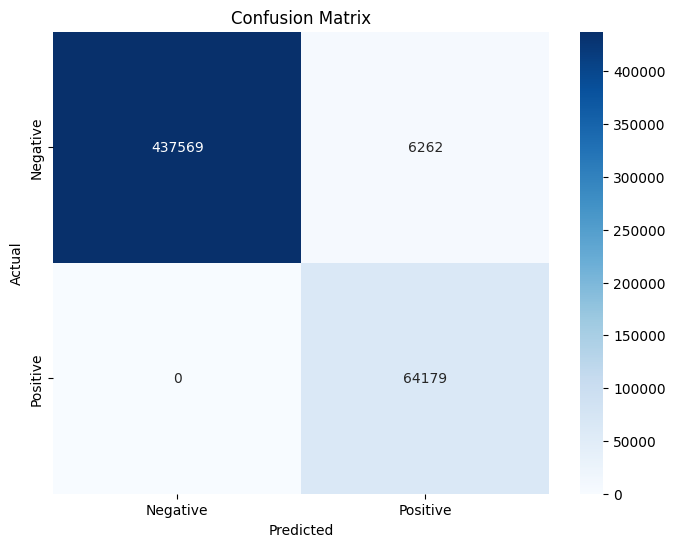

In [5]:
# Import the Neural Network and supporting functions.
from Models.models import NNdynamic, plot_metrics, plot_confusion_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
model1.load_model('./Models/saved_models/02/smote/01-256/PB_epoch_5.pth')
model1.test(test_loader)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
Testing: 100%|██████████| 3969/3969 [0

Test Loss: 0.0212, Test Accuracy: 0.9919, Test F1: 0.9917


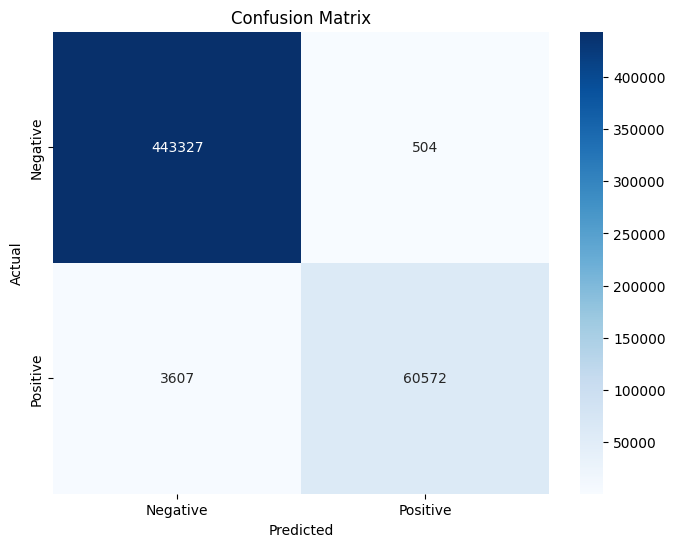

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)
model2.load_model('./Models/saved_models/02/standard/01/PB_epoch_5.pth')
model2.test(test_loader)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [7]:
background = X_test.sample(n=1000)
background = background.reset_index(drop=True)
background = torch.tensor(background.values, dtype=torch.float32)

In [8]:
X_test['actual'] = y_test
X_test['pred'] = model2.test_predicted

In [10]:
sample = X_test[(X_test['actual'] == 1) & (X_test['pred'] != 1)]
sample = sample.sample(n=1000)
sample = sample.reset_index(drop=True)
X_test = X_test.drop(columns=['actual', 'pred'])
sample = sample.drop(columns=['actual', 'pred'])
sample = torch.tensor(sample.values, dtype=torch.float32)

In [11]:
xp1 = shap.DeepExplainer(model1, background)
xp2 = shap.DeepExplainer(model2, background)

In [12]:
shap_values1 = xp1.shap_values(sample)
shap_values2 = xp2.shap_values(sample)

In [13]:
explainer1 = xp1(sample)
explainer2 = xp2(sample)

In [24]:
sm1 = SHAPmanager(shap_values1, explainer1, sample, feature_names=X_test.columns, label_type='binary')
sm2 = SHAPmanager(shap_values2, explainer2, sample, feature_names=X_test.columns, label_type='binary')

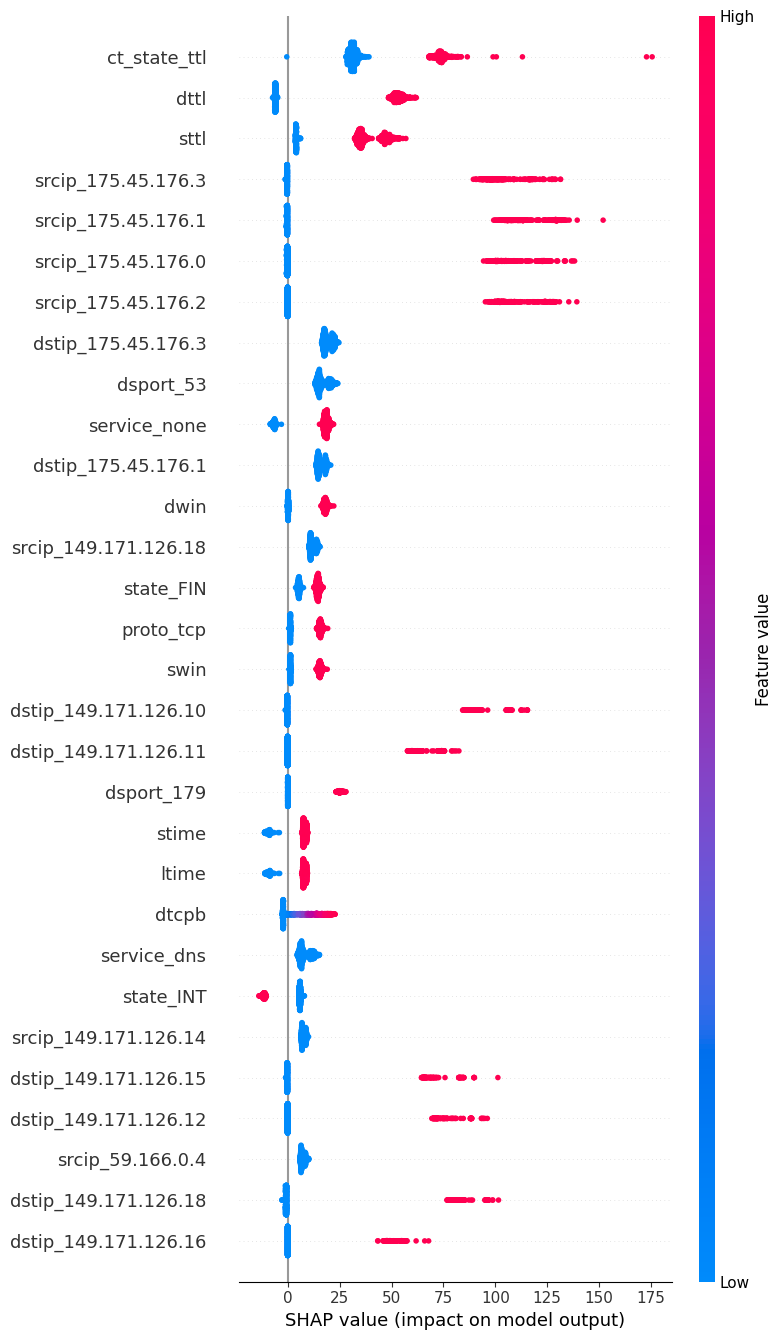

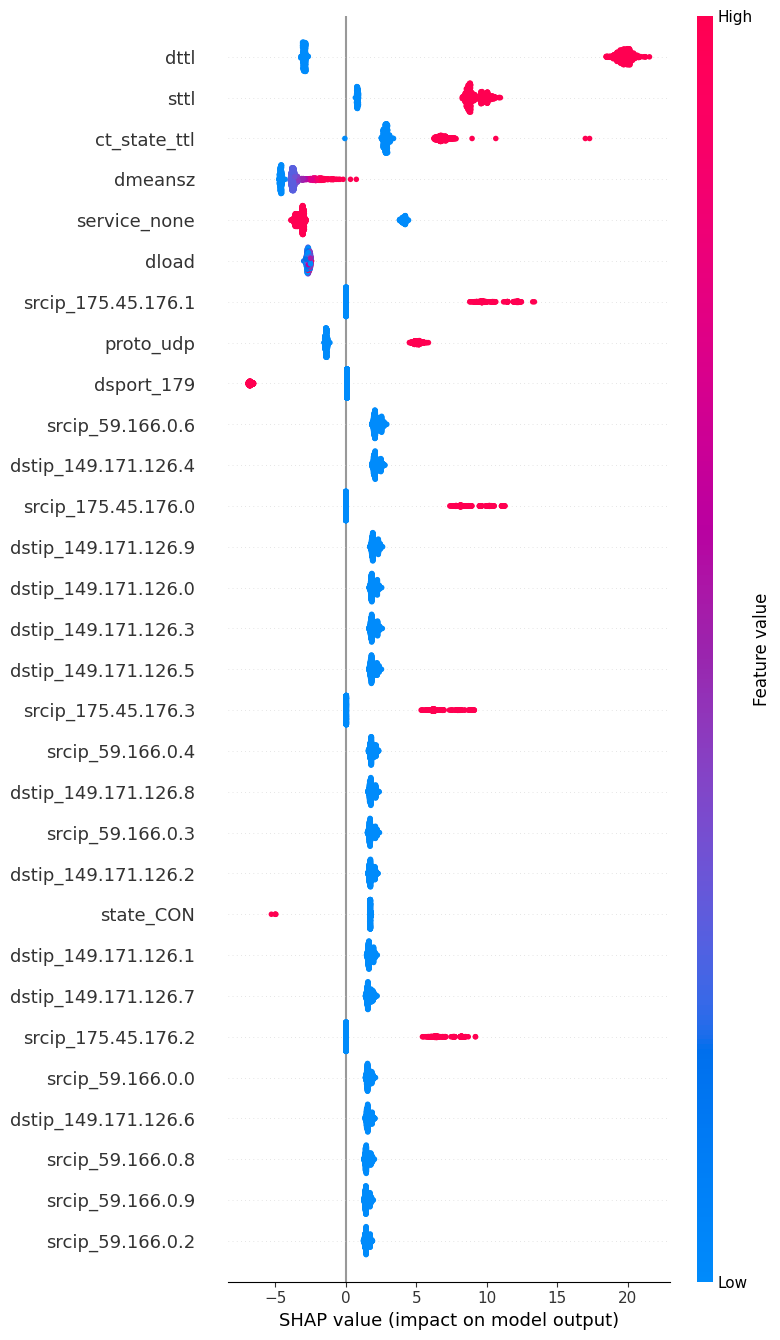

In [25]:
sm1.plot_summary('summary', 30, None)
sm2.plot_summary('summary', 30, None)

In [26]:
ips =  []

for i in X_test.columns:
    if i.startswith('srcip_') or i.startswith('dstip_'):
        ips.append(i)

In [27]:
sm1.remove_features(ips)
sm2.remove_features(ips)

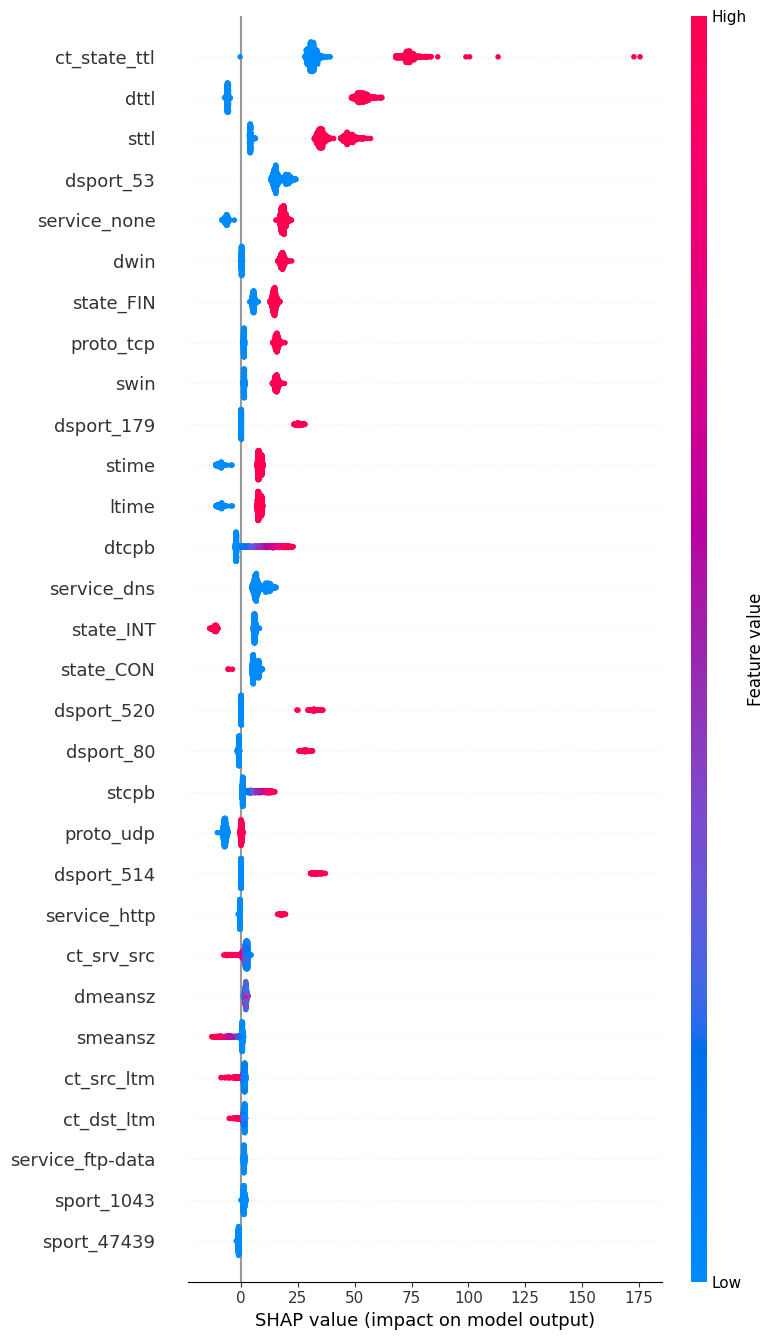

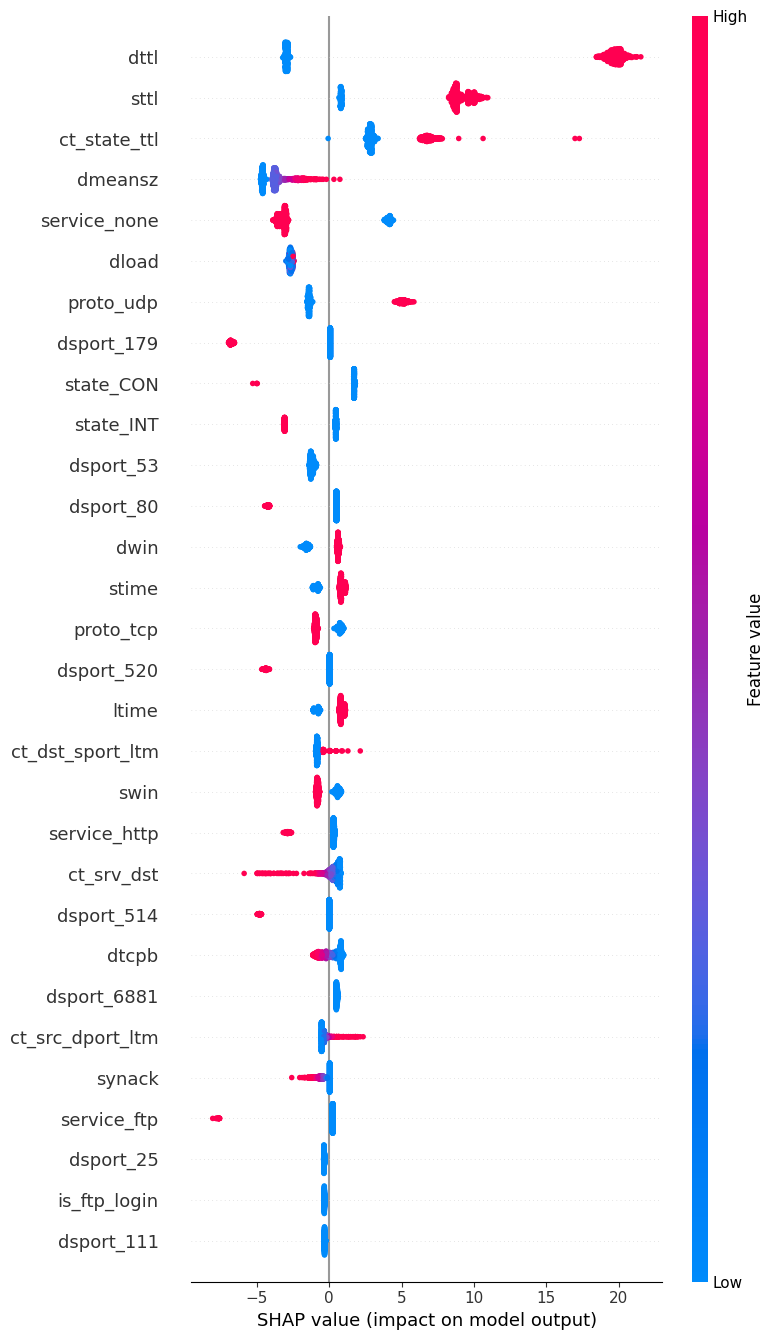

In [28]:
sm1.plot_summary('summary', 30, None)
sm2.plot_summary('summary', 30, None)

In [29]:
sm1.stacked_group('dsport', 30, 'average')
sm2.stacked_group('dsport', 30, 'average')

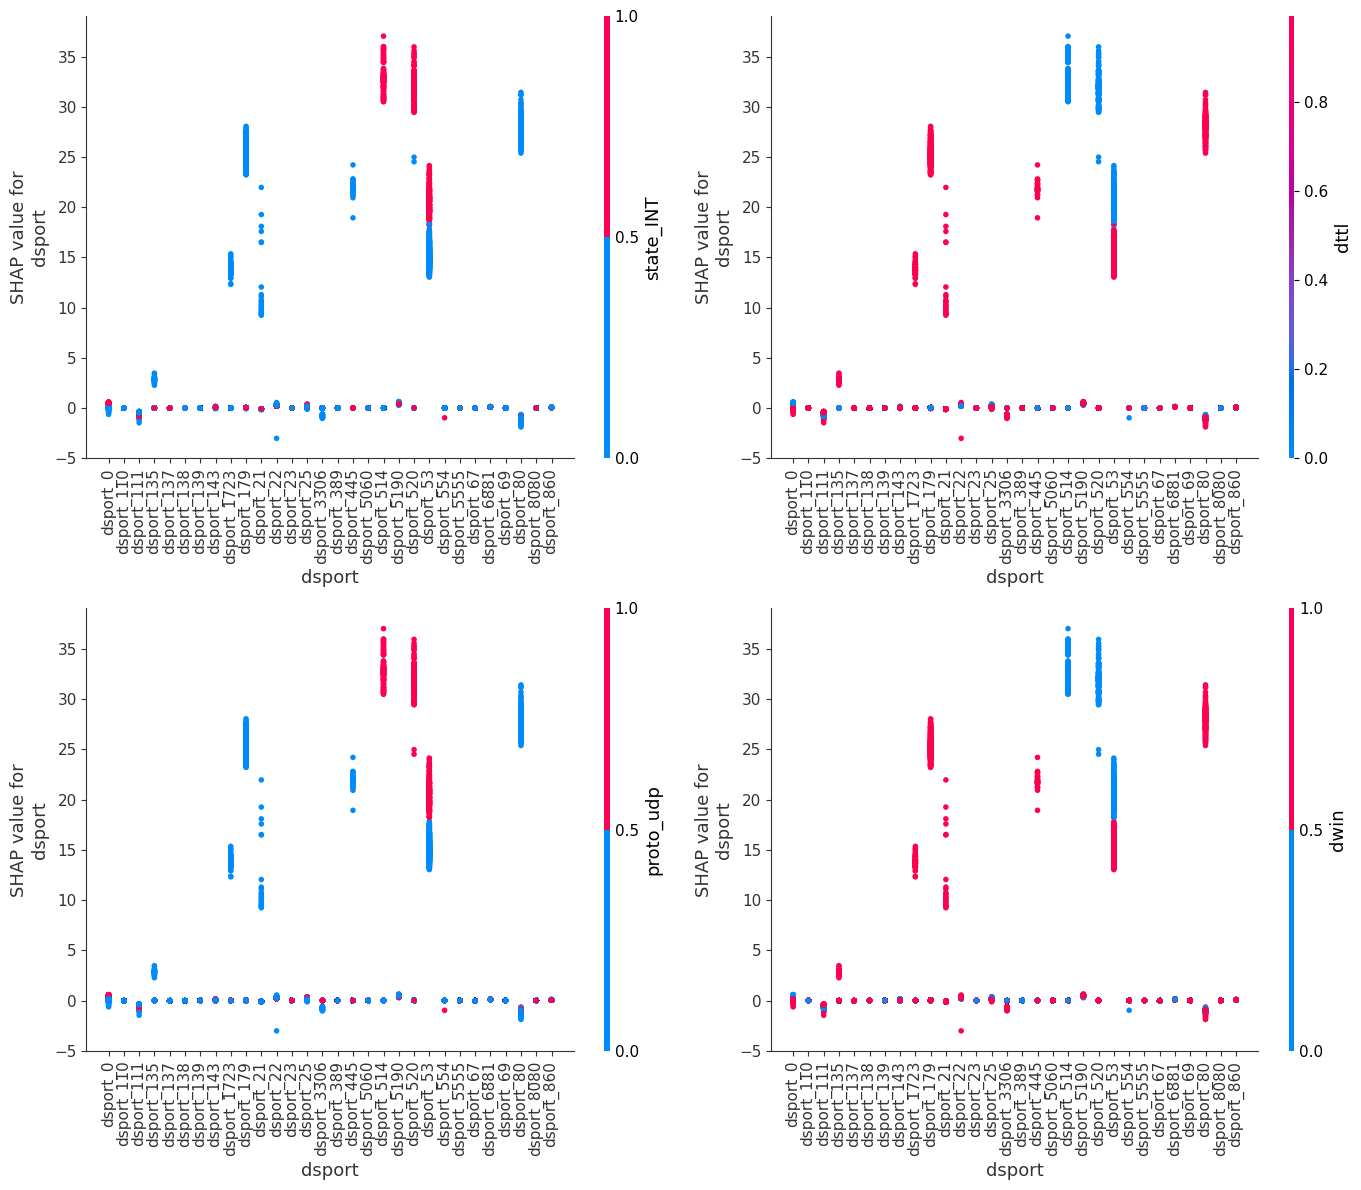

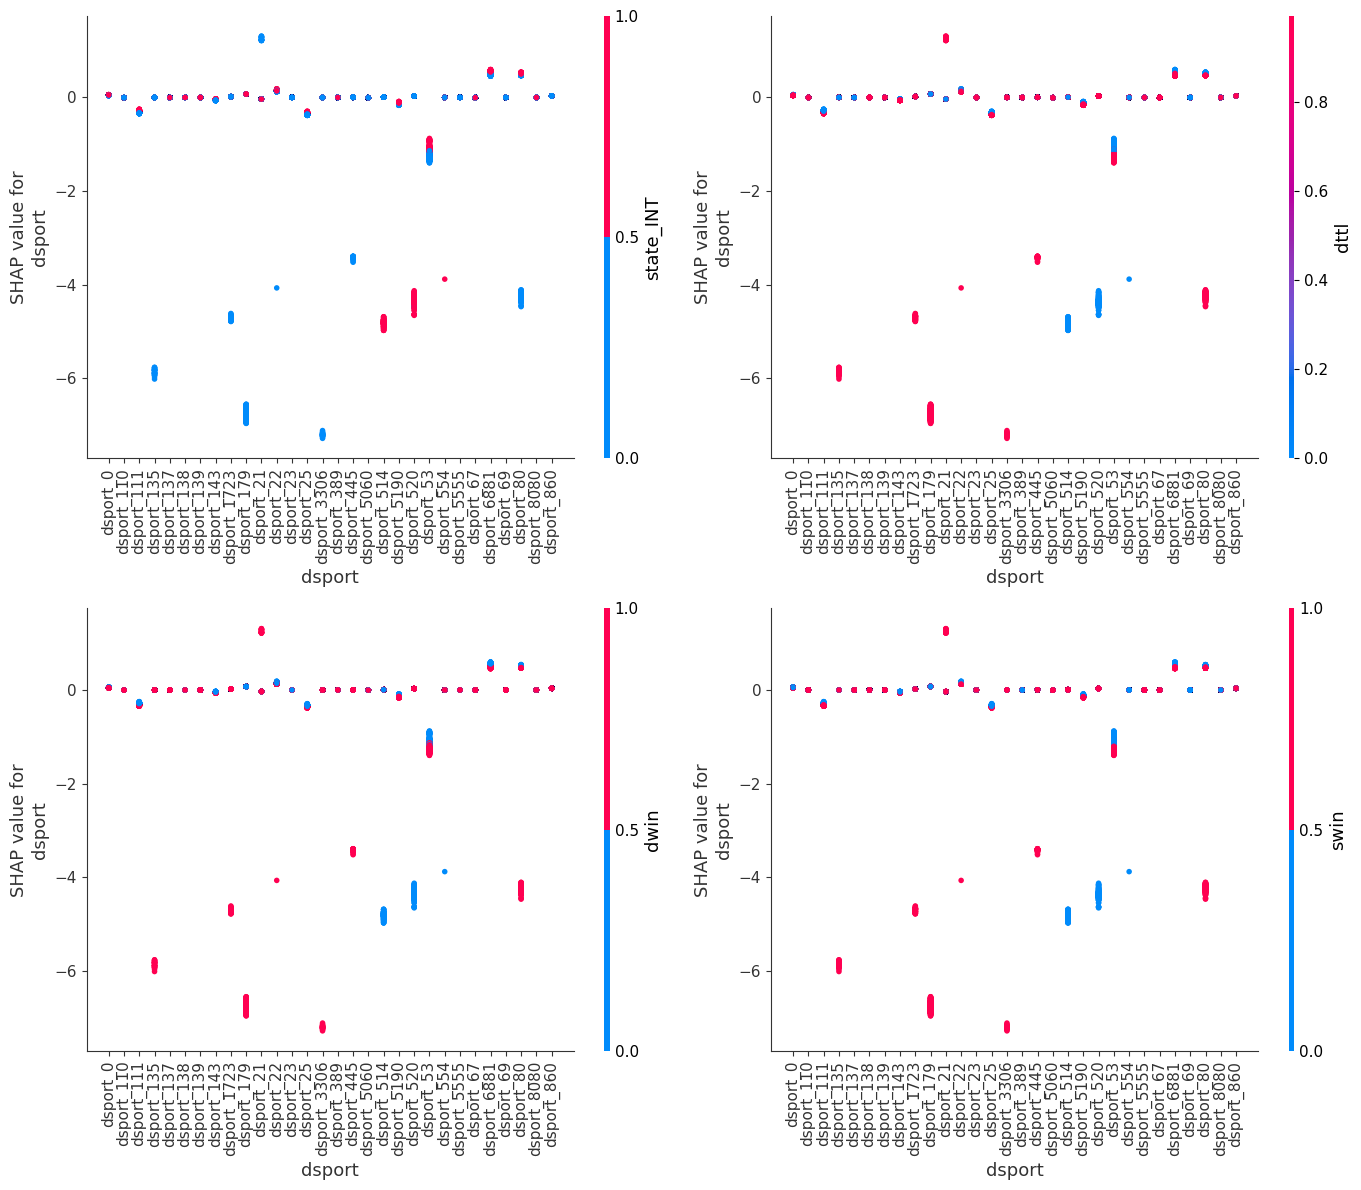

In [30]:
sm1.plot_dependence('dsport', 4)
sm2.plot_dependence('dsport', 4)